# Ocena jakości wina - projekt zespołowy PRiAD

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
wine = pd.read_csv('winequality-red.csv', sep=";", usecols = range(0,12))

<Figure size 3000x3000 with 0 Axes>

## Przedstawienie informacji o zbiorze

Ilość brakujących danych: 0
Ilość obiektów: 1599
Atrybuty: 
	fixed acidity
	volatile acidity
	citric acid
	residual sugar
	chlorides
	free sulfur dioxide
	total sulfur dioxide
	density
	pH
	sulphates
	alcohol
	quality


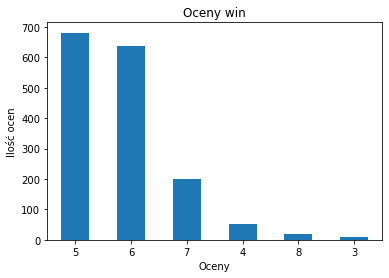

In [103]:
missingValues = wine.isnull().sum().sum()
numberOfObjects = len(wine)
print("Ilość brakujących danych: " + str(missingValues))
print("Ilość obiektów: " + str(numberOfObjects))
df = wine['quality'].value_counts().plot(kind="bar", rot=0, title="Oceny win", xlabel="Oceny", ylabel="Ilość ocen");
print("Atrybuty: ")
for col in wine.columns: 
    print("\t" + col)

## Analiza klasyfikacji atrybutów

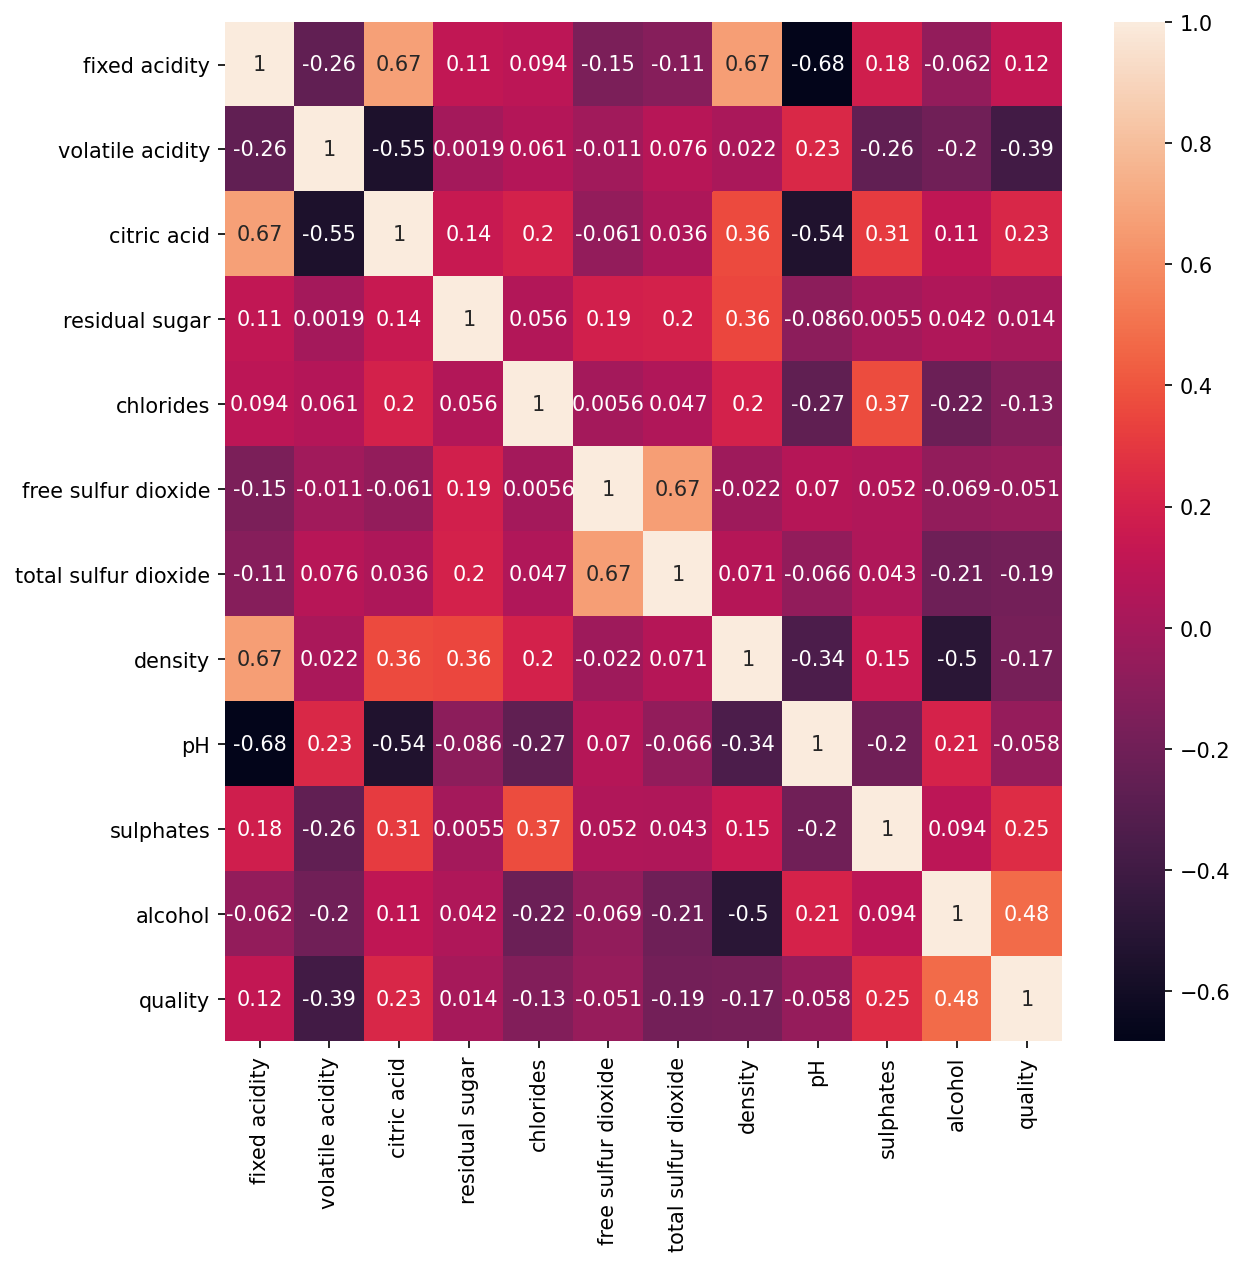

In [111]:
plt.figure(figsize=(9,9), dpi= 150);
sns.heatmap(wine.corr(), annot = wine.corr());

Atrybutami najbardziej wpływającymi na jakość wina są: 
- Alcohol
- Volatile acidity
- Sulphates
- Citric acid
- Total sulfur dioxide
- Density
- Chlorides
- Fixed acidity
- pH
- Free sulfur dioxide
- Residual sugar